In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from precip_model_functions import *#precip_model_OGorman,retrieve_modeled_precip,lr,lrp,corrc,corrp

In [2]:
#SEE https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding.html#sphx-glr-examples-advanced-sounding-py

# Functions

In [3]:
pa = np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
pressures  = pa * units.hPa

In [4]:
def era5_selection(ds,varid,lonlat=[],mask=1,level=-1,timemean=0,meandims=[],verbose=0):
    t=time.time()
    if timemean :
        temp = 0
    else :
        temp = []
    for i,d in enumerate(ds):
        try :
            era5var = xr.open_dataset(glob.glob(os.path.join(CMIP6_FOLDER,"ERA5/e5.oper.an.pl/*/e5.oper.an.pl.%s.*.%s00_%s23.nc"%(varid,d,d)))[0])
        except IndexError: #not a pl variable
            era5var = xr.open_dataset(glob.glob(os.path.join(CMIP6_FOLDER,"ERA5/*/*/*.%s.*.%s0100_%s??23.nc"%(varid,d[:-2],d[:-2])))[0])
        varname = list(era5var.data_vars)[0]

        # Select times
        if len(lonlat) == 0:
            era5var_xy = era5var[varname].sel(time=d).where(mask>0.5).isel(time=range(0,24,timedisc))
        else :
            era5var_xy = era5var[varname].sel(time=d,longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).isel(time=range(0,24,timedisc))#.where(mask>0.5)

        # Select level
        if level == -1:
            era5var_xyz = era5var_xy
        else :
            era5var_xyz = era5var_xy.sel(level=level)
        
        # Compute mean across variables 
        if not timemean :
            if len(meandims) == 0:
                print("no mean, mask not applied")
                era5var_xyzm = era5var_xyz
            else:
                era5var_xyzm = era5var_xyz.where(mask>0.5).mean(meandims)
            temp.append(era5var_xyzm)
        else :
            temp += era5var_xyz.where(mask>0.5).mean(meandims+["time"])
        if verbose :
            print("day %i %.1f"%(i,time.time()-t))
        
    if not timemean :
        return xr.concat(temp,'time')
    else :
        return temp/len(ds)

In [5]:
def era5_file(d,varid):
    """return file path to an ERA5 variable for the day 'd'
    varid gives the id of the variable in era5
        - d : str, "YYYYMMDD"
        - varid : str, eg. "128_130_t" for temperature
    """
    globpath = os.path.join(CMIP6_FOLDER,"ERA5/*/*/*.%s.*.%s00_%s23.nc"%(varid,d,d))
    path = glob.glob(globpath)[0]
 
    return path

def precip_era5_sel(ds,lonlat):
    return xr.concat([precipERA51d(d,lonlat) for d in ds],dim='time').mean("time")

def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean

In [6]:
#Data extraction from ERA5
import warnings
era5yrs = list(range(2010,2019))
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"

def era5_file(year,varid):
    """return file path to an ERA5 variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    try :
        fpath = glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    except IndexError :
        path = "/global/cscratch1/sd/qnicolas/era5monthly/"
        fpath = glob.glob(os.path.join(path,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    return fpath

def climatology_era5_level(varid,level,lonlat):
    t=time.time()
    paths = [era5_file(year,varid) for year in era5yrs]
    temp=0
    for p in paths:
        ds = xr.open_dataset(p)
        ds.coords['month'] = ds['time.month']
        ds = ds.swap_dims({'time': 'month'}).drop('time')
        temp2=ds.sel(level=level,longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
        if p == paths[0]:
            temp=temp2
        else :
            temp+=temp2
    varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    return temp[varname]/len(paths)


In [8]:
countries=['nepal','ghats','vietnam','Candes','Sandes','california','cascades']
t=time.time()
prs={ct : precip_era5_sel(p99_era5[ct],box[ct]["small"]) for ct in countries}
print(time.time()-t)

218.5701813697815


In [72]:
def pv_background(ct):
    pv_seasmean = climatology_era5_level('128_060_pv',500.,box[ct]["medium"])
    
    ndays=30
    months, count = np.unique([int(d[4:6]) for d in p99_era5[ct][-ndays:]], return_counts=True)
    temp=0
    for m,c in zip(months, count):
        temp+= pv_seasmean.sel(month=m)*(c/ndays)
    return temp
    

#t=time.time()
#capes={ct : era5_selection(p99_era5[ct],'128_059_cape',box[ct]["medium"],mask=1.,level=-1,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,cape in capes.items():
#    cape.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.128_059_cape.ll025sc.99pctile.%s.nc"%ct)

#t=time.time()
#pvbs={ct : pv_background(ct) for ct in countries[1:]}
#print(time.time()-t)
#for ct,ds in pvbs.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_060_pv.500mb.ll025sc.climatology99pctilemonths.%s.nc"%ct)

#t=time.time()
#uqs={ct : era5_selection(p99_era5[ct][-30:],'162_071_viwve',box[ct]["medium"],mask=1.,level=-1,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,ds in uqs.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.162_071_viwve.ll025sc.99pctile.%s.nc"%ct)
#

#t=time.time()
#vqs={ct : era5_selection(p99_era5[ct][-30:],'162_072_viwvn',box[ct]["medium"],mask=1.,level=-1,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,ds in vqs.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.162_072_viwvn.500mb.ll025sc.99pctile.%s.nc"%ct)
#

#t=time.time()
#u950s={ct : era5_selection(p99_era5[ct][-30:],'128_131_u',box[ct]["medium"],mask=1.,level=950.,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,ds in u950s.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_131_u.950mb.ll025sc.99pctile.%s.nc"%ct)

#t=time.time()
#v950s={ct : era5_selection(p99_era5[ct][-30:],'128_132_v',box[ct]["medium"],mask=1.,level=950.,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,ds in v950s.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_132_v.950mb.ll025sc.99pctile.%s.nc"%ct)

#t=time.time()
#tcwvs={ct : era5_selection(p99_era5[ct][-30:],'128_137_tcwv',box[ct]["medium"],mask=1.,level=-1,timemean=1,meandims=[],verbose=1) for ct in countries}
#print(time.time()-t)
#for ct,ds in tcwvs.items():
#    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.128_137_tcwv.ll025sc.99pctile.%s.nc"%ct)


day 0 4.8
day 1 6.6
day 2 8.2
day 3 10.1
day 4 11.7
day 5 13.6
day 6 15.4
day 7 17.2
day 8 18.9
day 9 20.5
day 10 22.1
day 11 23.8
day 12 25.4
day 13 27.2
day 14 28.9
day 15 30.6
day 16 32.3
day 17 34.0
day 18 35.5
day 19 37.2
day 20 38.9
day 21 40.7
day 22 42.3
day 23 44.0
day 24 45.7
day 25 47.3
day 26 49.2
day 27 51.0
day 28 52.6
day 29 54.1
day 30 55.7
day 31 57.1
day 32 58.6
day 33 60.5
day 34 62.3
day 35 64.0
day 36 65.8
day 37 67.4
day 38 69.0
day 39 70.7
day 40 72.5
day 41 74.5
day 42 76.3
day 43 78.0
day 44 79.4
day 45 81.0
day 46 82.9
day 47 84.9
day 48 86.8
day 49 88.5
day 50 90.1
day 51 91.8
day 52 93.5
day 53 95.3
day 54 97.2
day 55 98.8
day 56 100.3
day 57 101.9
day 58 103.5
day 59 105.1
day 60 106.8
day 61 108.3
day 62 109.9
day 63 111.7
day 64 113.2
day 65 114.8
day 66 116.7
day 67 118.2
day 68 120.0
day 69 121.3
day 70 122.9
day 71 124.6
day 72 126.5
day 73 128.2
day 74 130.0
day 75 131.8
day 76 133.6
day 77 135.1
day 78 136.8
day 79 138.3
day 80 140.1
day 81 141.6
day

In [15]:
t=time.time()
u500s={ct : era5_selection(p99_era5[ct][-10:],'128_131_u',box[ct]["medium"],mask=1.,level=500.,timemean=1,meandims=[],verbose=1) for ct in countries}
print(time.time()-t)
for ct,ds in u500s.items():
    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_131_u.500mb.ll025sc.99pctile.%s.nc"%ct)

t=time.time()
v500s={ct : era5_selection(p99_era5[ct][-10:],'128_132_v',box[ct]["medium"],mask=1.,level=500.,timemean=1,meandims=[],verbose=1) for ct in countries}
print(time.time()-t)
for ct,ds in v500s.items():
    ds.to_netcdf("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_132_v.500mb.ll025sc.99pctile.%s.nc"%ct)


day 0 7.0
day 1 13.9
day 2 21.0
day 3 28.3
day 4 35.0
day 5 41.7
day 6 48.6
day 7 55.0
day 8 62.3
day 9 69.4
day 0 7.0
day 1 14.3
day 2 21.8
day 3 29.5
day 4 36.8
day 5 44.8
day 6 52.5
day 7 60.5
day 8 68.0
day 9 75.1
day 0 7.8
day 1 14.9
day 2 22.5
day 3 30.4
day 4 38.3
day 5 46.2
day 6 54.7
day 7 63.6
day 8 71.2
day 9 78.7
day 0 6.7
day 1 14.8
day 2 22.5
day 3 29.3
day 4 37.1
day 5 44.1
day 6 51.6
day 7 58.8
day 8 66.9
day 9 75.2
day 0 8.2
day 1 15.6
day 2 23.7
day 3 31.0
day 4 37.9
day 5 45.6
day 6 53.2
day 7 60.6
day 8 67.9
day 9 76.6
day 0 7.9
day 1 15.2
day 2 22.6
day 3 30.4
day 4 37.8
day 5 45.4
day 6 53.4
day 7 60.9
day 8 68.8
day 9 76.1
day 0 7.4
day 1 14.8
day 2 22.6
day 3 30.2
day 4 39.5
day 5 48.0
day 6 56.3
day 7 64.1
day 8 71.2
day 9 78.3
529.3566370010376
day 0 8.3
day 1 16.2
day 2 24.9
day 3 32.9
day 4 40.6
day 5 48.7
day 6 56.6
day 7 63.9
day 8 72.0
day 9 79.8
day 0 7.9
day 1 16.1
day 2 23.8
day 3 31.3
day 4 39.1
day 5 47.5
day 6 55.3
day 7 63.0
day 8 71.0
day 9 78.5
d

In [9]:
ps = xr.open_dataset(era5_file("2010",'128_134_sp')).mean("time").SP
capes= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.128_059_cape.ll025sc.99pctile.%s.nc"%ct).CAPE for ct in countries}
pvs  = {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_060_pv.500mb.ll025sc.99pctile.%s.nc"%ct).PV for ct in countries}
pvbs = {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_060_pv.500mb.ll025sc.climatology99pctilemonths.%s.nc"%ct).PV for ct in countries}
uqs  = {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.162_071_viwve.ll025sc.99pctile.%s.nc"%ct).VIWVE for ct in countries}
vqs  = {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.162_072_viwvn.ll025sc.99pctile.%s.nc"%ct).VIWVN for ct in countries}
u500s= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_131_u.500mb.ll025uv.99pctile.%s.nc"%ct).U for ct in countries}
v500s= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_132_v.500mb.ll025uv.99pctile.%s.nc"%ct).V for ct in countries}
u950s= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_131_u.950mb.ll025uv.99pctile.%s.nc"%ct).U for ct in countries}
v950s= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.pl.128_132_v.950mb.ll025uv.99pctile.%s.nc"%ct).V for ct in countries}
tcwvs= {ct : xr.open_dataset("/global/cscratch1/sd/qnicolas/data/composites/e5.oper.an.sfc.128_137_tcwv.ll025sc.99pctile.%s.nc"%ct).TCWV for ct in countries}



# Precip maps

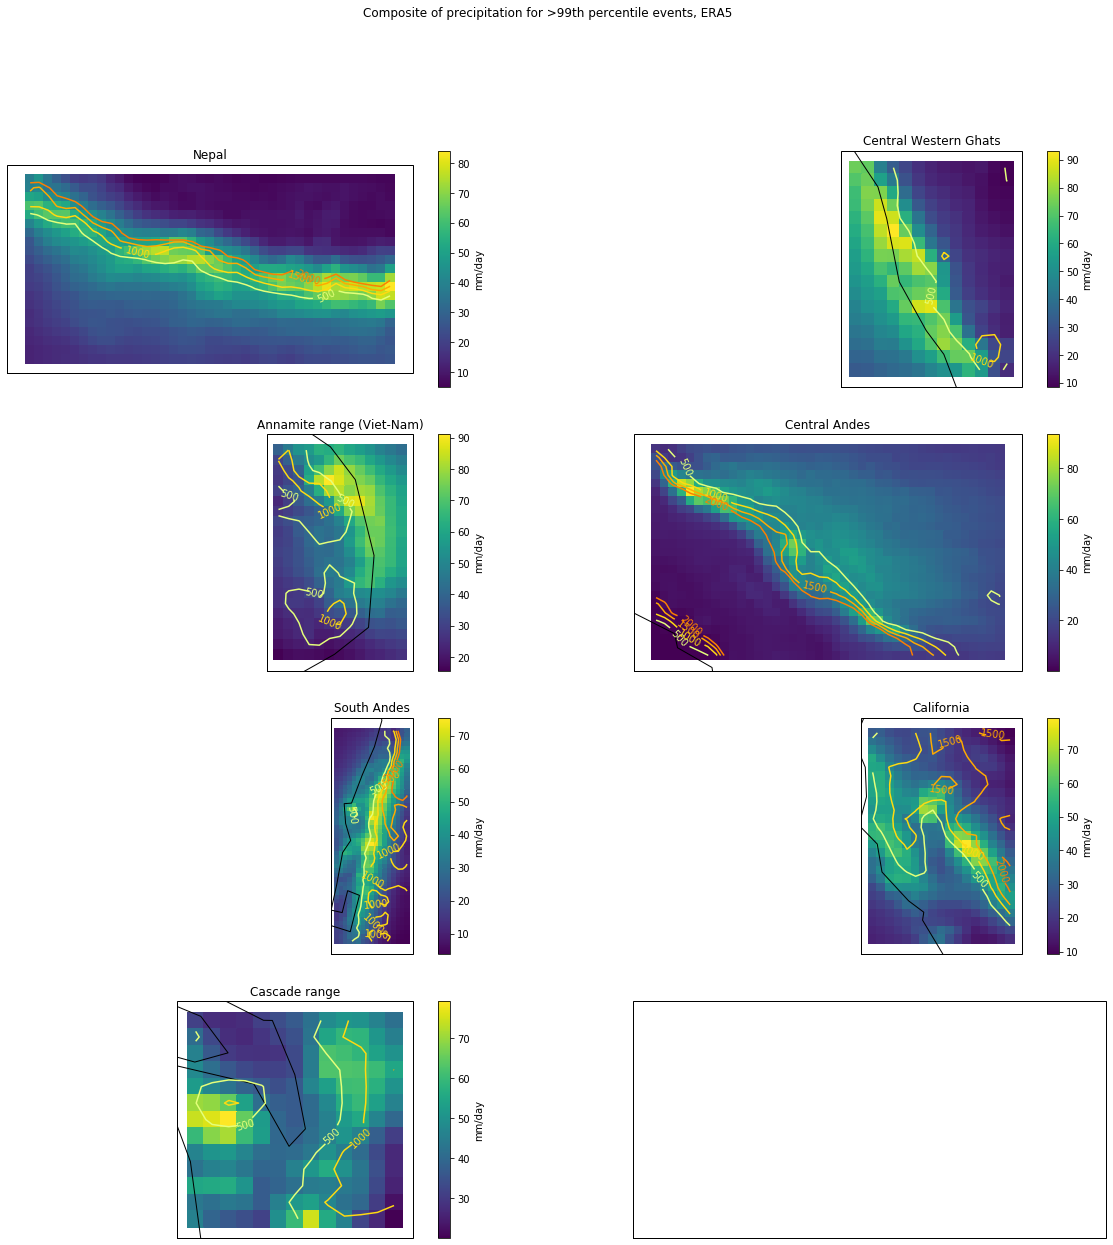

In [7]:
fig, ax = plt.subplots(4,2,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.reshape(-1)
fig.suptitle("Composite of precipitation for >99th percentile events, ERA5")
for i,ct in enumerate(countries):
    prs[ct].plot(ax=ax[i],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day"})#,"ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
    kw = {'levels':[500.,1000.,1500.,2000.], 'cmap' : plt.cm.Wistia}#['r','g','b','k']}#plt.cm.viridis(100)}
    lonlat=box[ct]["small"]
    contour = orog.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=ax[i],transform=ccrs.PlateCarree(),**kw)
    ax[i].clabel(contour, inline=1, fontsize=10, fmt="%i")
    ax[i].set_title(names[ct])
    ax[i].coastlines()
    
    
    
    #trmmmask = cartopy.feature.ShapelyFeature(mask,ccrs.PlateCarree())
    #ax[0].add_feature(trmmmask, zorder=100, edgecolor='k')



# CAPE maps

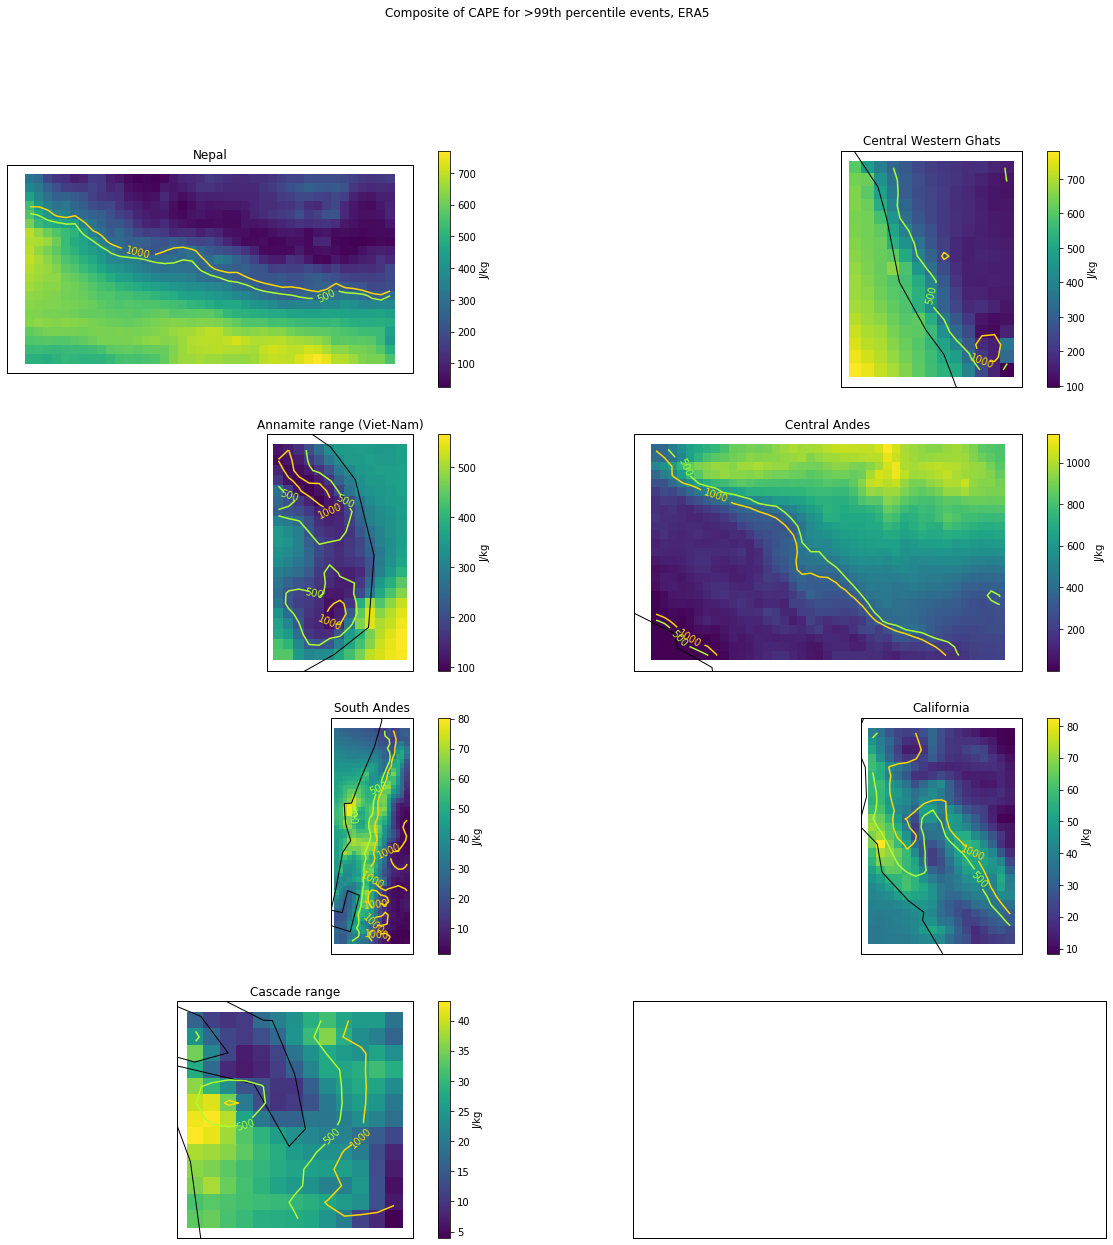

In [77]:
fig, ax = plt.subplots(4,2,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.reshape(-1)
fig.suptitle("Composite of CAPE for >99th percentile events, ERA5")
for i,ct in enumerate(countries):
    lonlat=box[ct]["small"]
    capes[ct].sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot(ax=ax[i],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"J/kg"})#,"ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
    kw = {'levels':[500.,1000.], 'colors':['greenyellow','gold']}#,'linewidths':0.5}
    contour=orog.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=ax[i],transform=ccrs.PlateCarree(),**kw)
    ax[i].clabel(contour, inline=1, fontsize=10, fmt="%i")
    
    ax[i].set_title(names[ct])
    ax[i].coastlines()
    

# Skew-T

In [71]:
def plot_skewT(p,T,r,legend=""):
    T = np.array(T-273.15) * units.degC
    r = np.array(r)/100
    Td = mpcalc.dewpoint_from_relative_humidity(T,r)
    
    fig = plt.figure(figsize=(7, 7))
    skew = SkewT(fig, rotation=45)
    
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')

    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    
    # Calculate LCL height and plot as black dot. 
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[-1], T[-1], Td[-1])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p[::-1], T[-1], Td[-1]).to('degC')[::-1]
    skew.plot(p, prof, 'k', linewidth=2)
    
    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, prof)
    skew.shade_cape(p, T, prof)
    
    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    # Show the plot
    plt.title("Skew T diagram - "+legend)
    plt.show()
    
    #compute cape
    cape,_=mpcalc.cape_cin(p[::-1],T[::-1],Td[::-1],prof[::-1])
    caperound = int(100*np.array(cape))/100
    print("CAPE :",caperound*units('J/kg'))
    
def plot_skewT_country(ct):
    t=time.time()
    T = era5_selection(p99_era5[ct][-15:],'128_130_t',box[ct]["small"],mask=1.*(prs[ct]>40.),level=-1,timemean=1,meandims=["latitude","longitude"])
    print("done T %.1f s"%(time.time()-t))
    r = era5_selection(p99_era5[ct][-15:],'128_157_r',box[ct]["small"],mask=1.*(prs[ct]>40.),level=-1,timemean=1,meandims=["latitude","longitude"])
    print("done RH %.1f s"%(time.time()-t))
    plot_skewT(pressures,T,r,legend=names[ct])

done 65.8 s
130.30945801734924


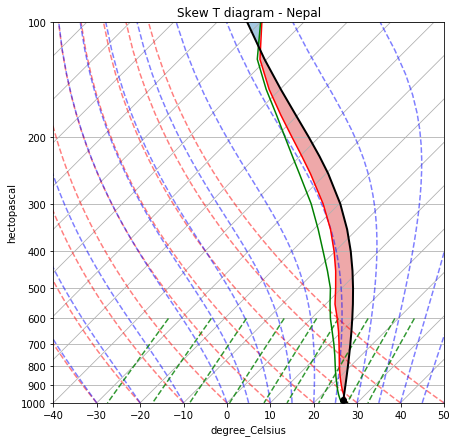

CAPE : 1904.87 joule / kilogram
done 67.1 s
131.09124183654785


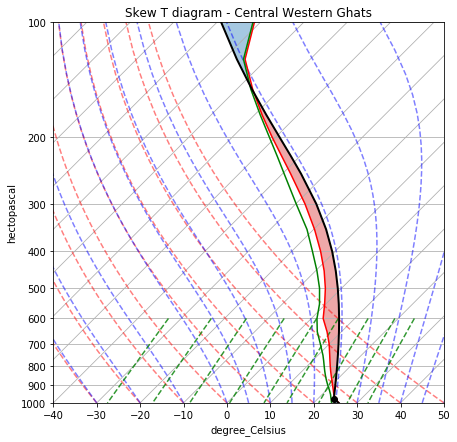

CAPE : 1138.73 joule / kilogram
done 65.6 s
132.3671374320984


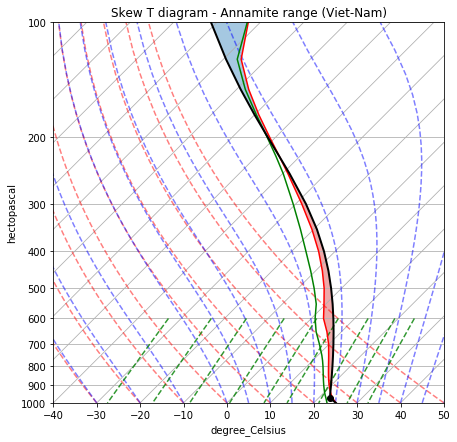

CAPE : 463.17 joule / kilogram
done 64.5 s
129.9330747127533


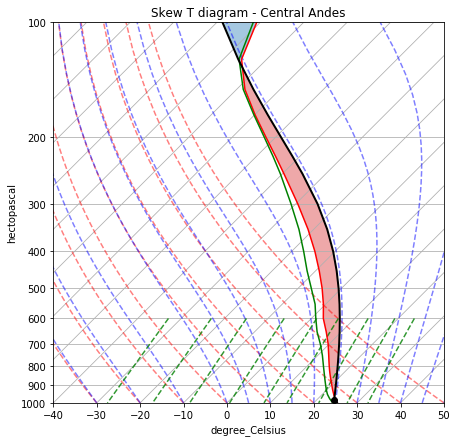

CAPE : 1848.53 joule / kilogram
done 65.2 s
134.81500244140625


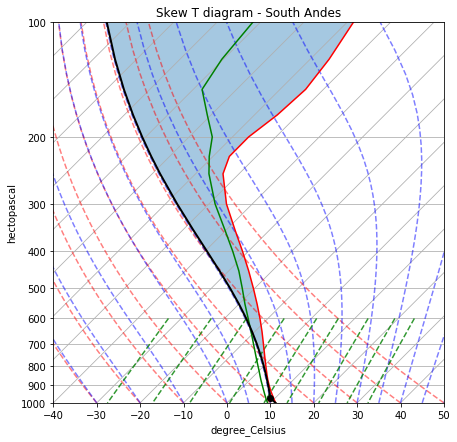

CAPE : 0.0 joule / kilogram
done 66.5 s
130.49366164207458


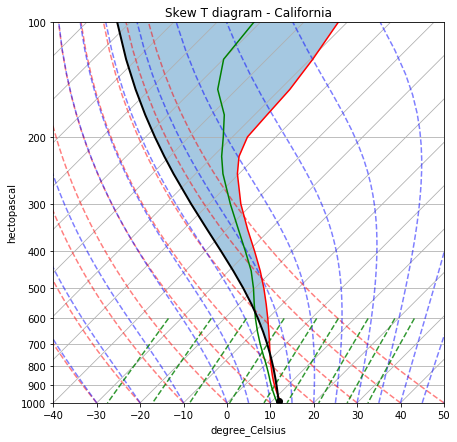

CAPE : 27.62 joule / kilogram
done 64.0 s
127.71988892555237


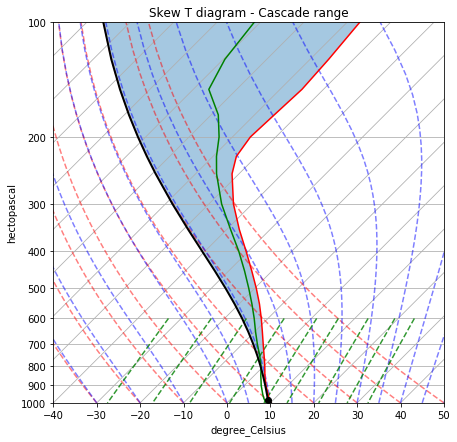

CAPE : 0.0 joule / kilogram


In [20]:
for ct in countries :
    plot_skewT_country(ct)

# Old Skew-Ts

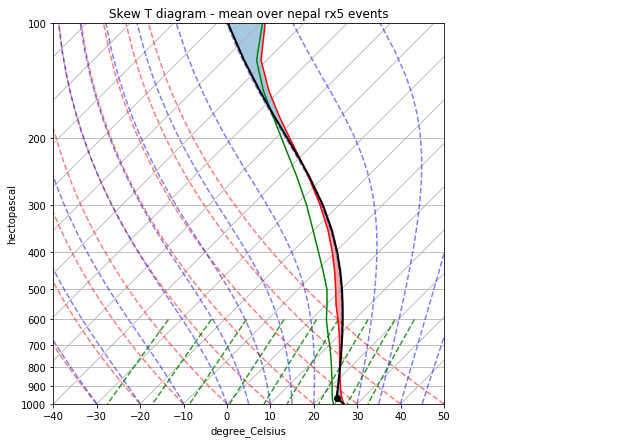

CAPE : 298.45 joule / kilogram


In [49]:
plot_skewT(pressures,Tnepal,Tdnepal,legend="mean over nepal rx5 events")

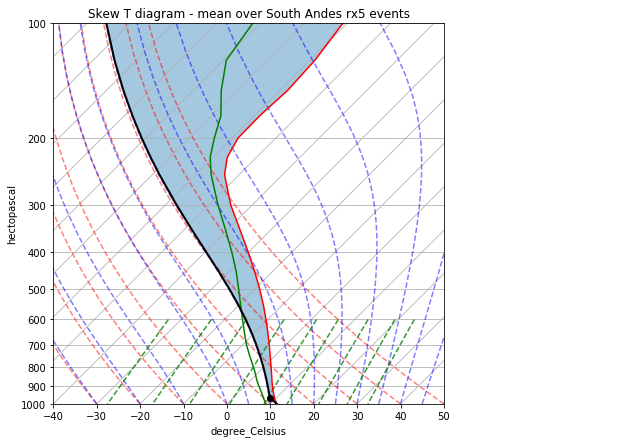

CAPE : 0.0 joule / kilogram


In [50]:
plot_skewT(pressures,TSandes,TdSandes,legend="mean over South Andes rx5 events")

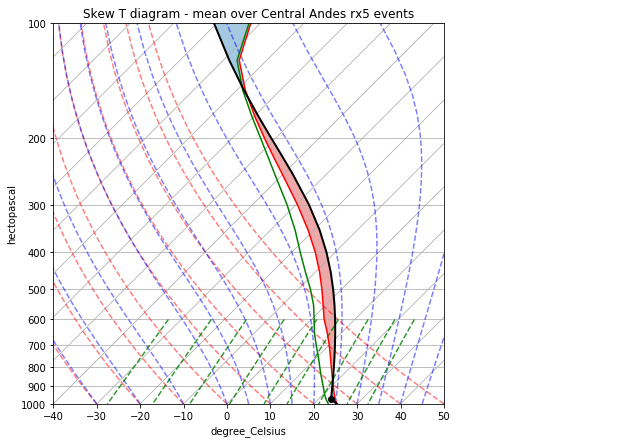

CAPE : 968.12 joule / kilogram


In [51]:
plot_skewT(pressures,TCandes,TdCandes,legend="mean over Central Andes rx5 events")

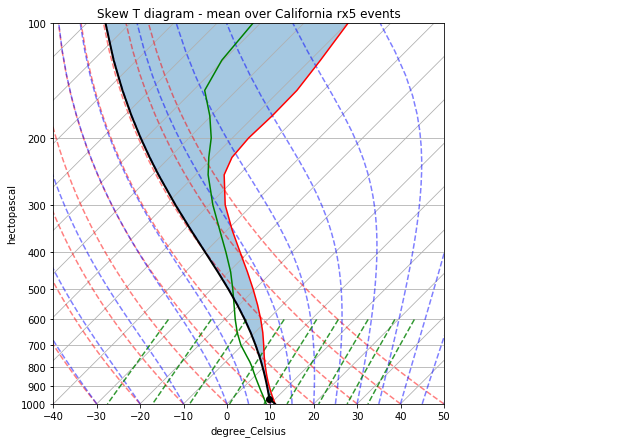

CAPE : 0.0 joule / kilogram


In [11]:
plot_skewT(pressures,Tcalifornia,Tdcalifornia,legend="mean over California rx5 events")

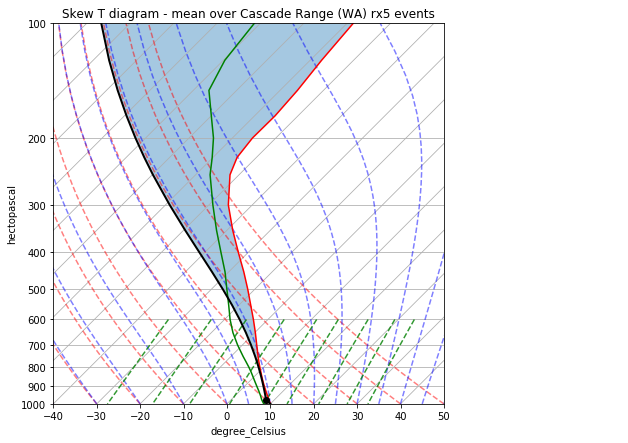

CAPE : 0.0 joule / kilogram


In [12]:
plot_skewT(pressures,Tcascades,Tdcascades,legend="mean over Cascade Range (WA) rx5 events")

# PV composites

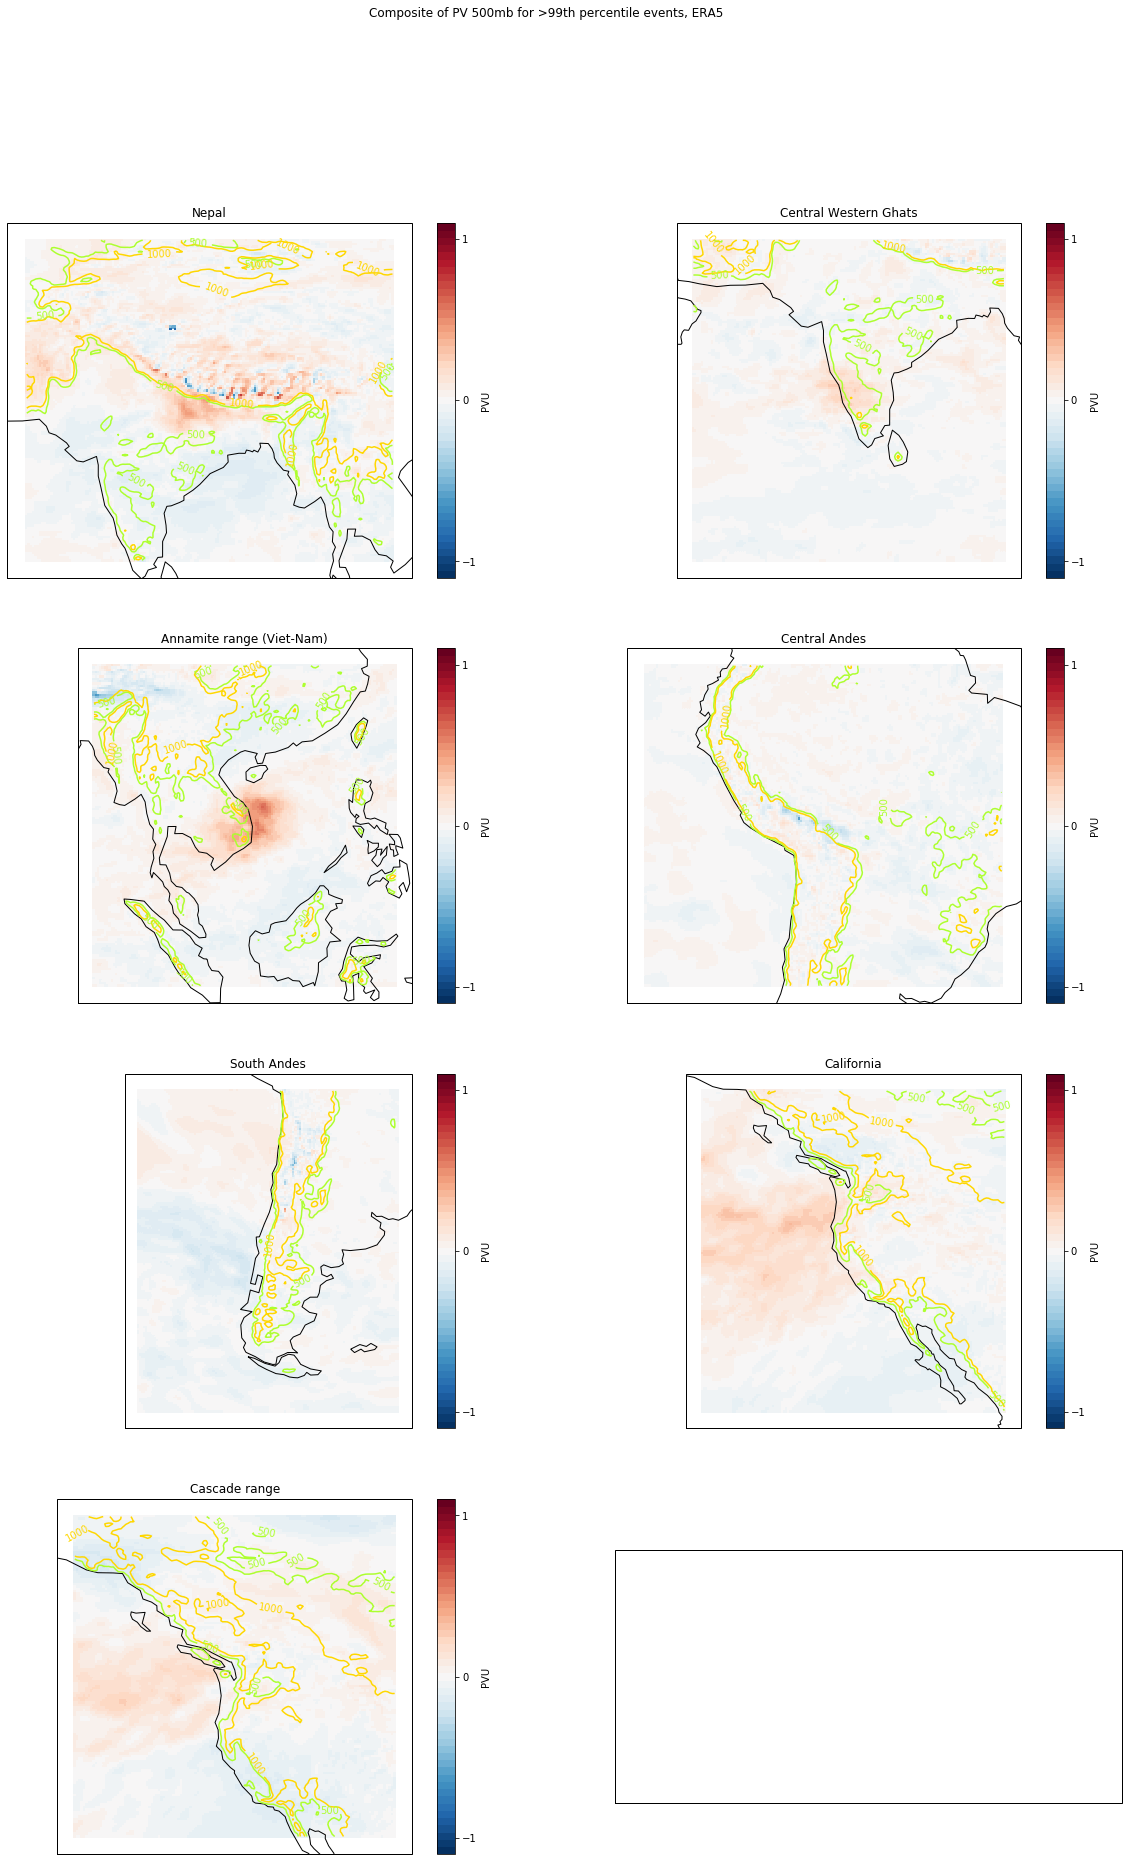

In [142]:
fig, ax = plt.subplots(4,2,figsize=(20,30),subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.reshape(-1)
fig.suptitle("Composite of PV 500mb for >99th percentile events, ERA5")
for i,ct in enumerate(countries):
    lonlat=box[ct]["medium"]
    (1e6*(pvs[ct]-pvbs[ct])).where(ps>50000.).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot(ax=ax[i],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"PVU","ticks":[-1,0,1]},levels=np.linspace(-1.1,1.1))#,"ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
    kw = {'levels':[500.,1000.], 'colors':['greenyellow','gold']}#,'linewidths':0.5}
    contour=orog.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=ax[i],transform=ccrs.PlateCarree(),**kw)
    ax[i].clabel(contour, inline=1, fontsize=10, fmt="%i")
    
    ax[i].set_title(names[ct])
    ax[i].coastlines()
    

# Moisture composites

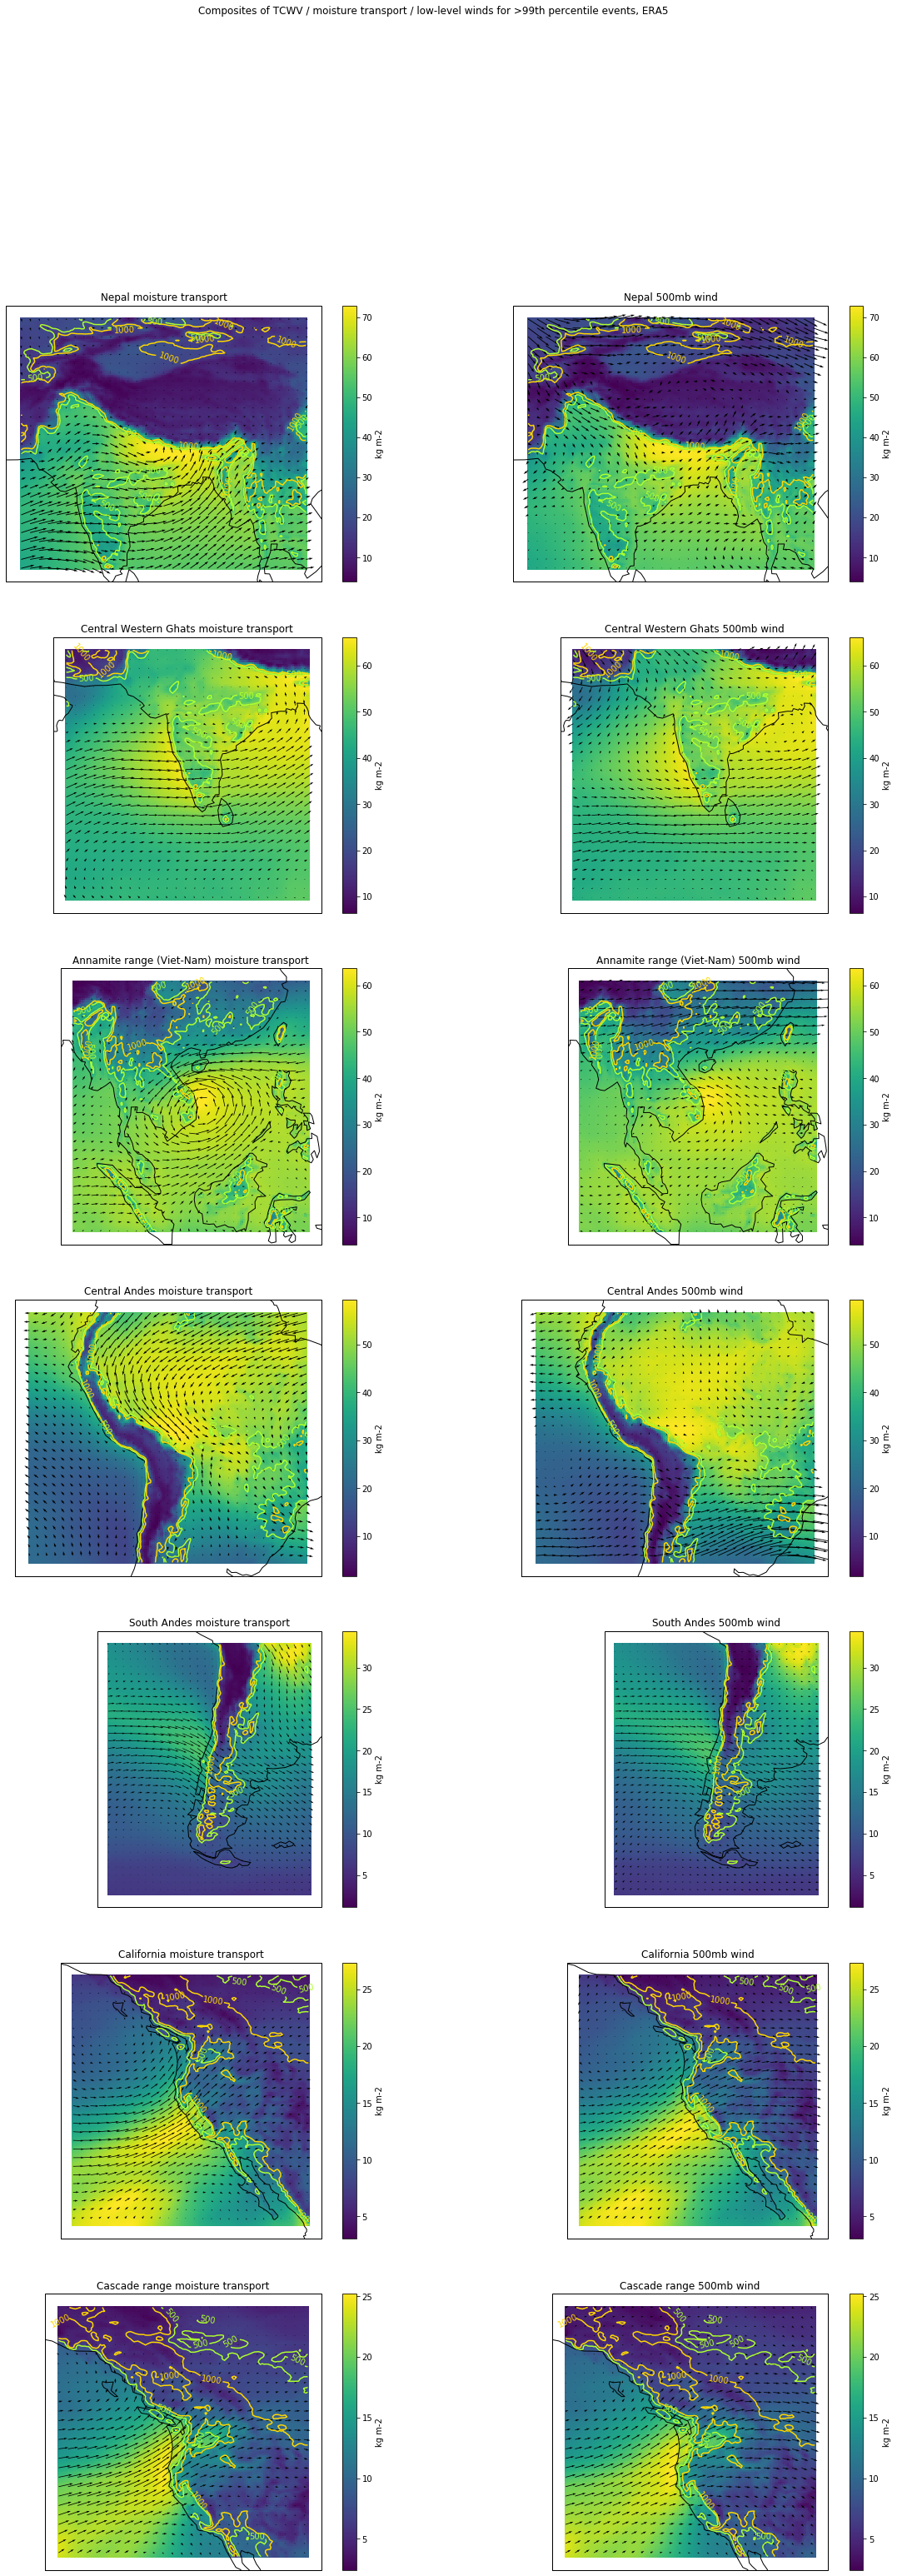

In [16]:
fig, ax = plt.subplots(7,2,figsize=(20,50),subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Composites of TCWV / moisture transport / low-level winds for >99th percentile events, ERA5")
for i,ct in enumerate(countries):
    lonlat=box[ct]["medium"]
    for a in ax[i]:
        tcwvs[ct].sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot(ax=a,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"kg m-2"})
        kw = {'levels':[500.,1000.], 'colors':['greenyellow','gold']}#,'linewidths':0.5}
        contour=orog.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=a,transform=ccrs.PlateCarree(),**kw)
        a.clabel(contour, inline=1, fontsize=10, fmt="%i")
        a.coastlines()
    ax[i][0].set_title(names[ct]+ " moisture transport")
    ax[i][1].set_title(names[ct]+ " 500mb wind")
    
    #Wind Vectors
    for a,uq,vq in zip(ax[i],[uqs[ct],u500s[ct]],[vqs[ct],v500s[ct]]):
        uq=uq.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))[::5,::5]
        vq=vq.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))[::5,::5]
        X = uq.latitude.expand_dims({"longitude":uq.longitude}).transpose()
        Y = uq.longitude.expand_dims({"latitude":uq.latitude})
        Q = a.quiver(np.array(Y),np.array(X), np.array(uq), np.array(vq), transform=ccrs.PlateCarree(),color="k",linewidth=1)#,scale=100,scale_units="height") #np.hypot(np.array(u),np.array(v)) to color the arrows according to magnitude
        #qk = a.quiverkey(Q, 0., 0., 1, '1 kg/m/s', labelpos='E',coordinates='figure')
    